## Title of Project: Image enhancement using SRGAN on DIV2K Dataset
## By Aditya Raj Sahoo

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d sharansmenon/div2k

100% 3.69G/3.71G [00:35<00:00, 149MB/s]
100% 3.71G/3.71G [00:35<00:00, 111MB/s]


In [ ]:
# Model trained on DIV2K Dataset (on bicubically downsampled images) on image patches of size 128 x 128.
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

In [ ]:
!unzip div2k.zip

Archive:  div2k.zip
  inflating: DIV2K_train_HR/DIV2K_train_HR/0001.png  
  inflating: DIV2K_train_HR/DIV2K_train_HR/0002.png  
  inflating: DIV2K_train_HR/DIV2K_train_HR/0003.png  
  inflating: DIV2K_train_HR/DIV2K_train_HR/0004.png  
  inflating: DIV2K_train_HR/DIV2K_train_HR/0005.png  
  inflating: DIV2K_train_HR/DIV2K_train_HR/0006.png  
  inflating: DIV2K_train_HR/DIV2K_train_HR/0007.png  
  inflating: DIV2K_train_HR/DIV2K_train_HR/0008.png  
  inflating: DIV2K_train_HR/DIV2K_train_HR/0009.png  
  inflating: DIV2K_train_HR/DIV2K_train_HR/0010.png  
  inflating: DIV2K_train_HR/DIV2K_train_HR/0011.png  
  inflating: DIV2K_train_HR/DIV2K_train_HR/0012.png  
  inflating: DIV2K_train_HR/DIV2K_train_HR/0013.png  
  inflating: DIV2K_train_HR/DIV2K_train_HR/0014.png  
  inflating: DIV2K_train_HR/DIV2K_train_HR/0015.png  
  inflating: DIV2K_train_HR/DIV2K_train_HR/0016.png  
  inflating: DIV2K_train_HR/DIV2K_train_HR/0017.png  
  inflating: DIV2K_train_HR/DIV2K_train_HR/0018.png  
  inflat

In [ ]:
import cv2
img = cv2.imread("/content/DIV2K_train_HR/DIV2K_train_HR/0001.png")
img = cv2.resize(img, (224, 224))

In [ ]:
cv2.imwrite("0001.png",img)

True

In [ ]:
# Declaring Constants
IMAGE_PATH = "0001.png"
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

In [ ]:
def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)

In [ ]:
%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image,"gray")
  plt.axis("off")
  plt.title(title)

In [ ]:
hr_image = preprocess_image(IMAGE_PATH)

Saved as /content/0001.png.jpg


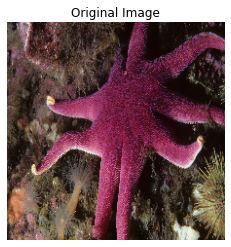

In [ ]:
# Plotting Original Resolution image
plot_image(tf.squeeze(hr_image), title="Original Image")
save_image(tf.squeeze(hr_image), filename="/content/0001.png")

In [ ]:
model = hub.load(SAVED_MODEL_PATH)

Downloaded https://tfhub.dev/captain-pool/esrgan-tf2/1, Total size: 20.60MB



In [ ]:
start = time.time()
fake_image = model(hr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 13.907745


Saved as Super Resolution.jpg


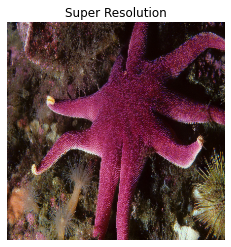

In [ ]:
# Plotting Super Resolution Image
plot_image(tf.squeeze(fake_image), title="Super Resolution")
save_image(tf.squeeze(fake_image), filename="Super Resolution")

In [ ]:
# Defining helper functions
def downscale_image(image):
  """
      Scales down images using bicubic downsampling.
      Args:
          image: 3D or 4D tensor of preprocessed image
  """
  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
  else:
    raise ValueError("Dimension mismatch. Can work only on single image.")

  image = tf.squeeze(
      tf.cast(
          tf.clip_by_value(image, 0, 255), tf.uint8))

  lr_image = np.asarray(
    Image.fromarray(image.numpy())
    .resize([image_size[0] // 4, image_size[1] // 4],
              Image.BICUBIC))

  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image

In [ ]:
hr_image = preprocess_image(IMAGE_PATH)

In [ ]:
lr_image = downscale_image(tf.squeeze(hr_image))

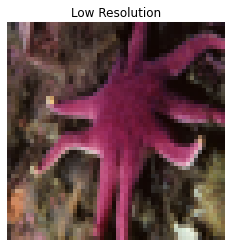

In [ ]:
# Plotting Low Resolution Image
plot_image(tf.squeeze(lr_image), title="Low Resolution")

In [ ]:
model = hub.load(SAVED_MODEL_PATH)

In [ ]:
start = time.time()
fake_image = model(lr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 2.840160


PSNR Achieved: 22.141644


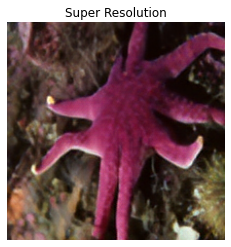

In [ ]:
plot_image(tf.squeeze(fake_image), title="Super Resolution")
# Calculating PSNR wrt Original Image
psnr = tf.image.psnr(
    tf.clip_by_value(fake_image, 0, 255),
    tf.clip_by_value(hr_image, 0, 255), max_val=255)
print("PSNR Achieved: %f" % psnr)

PSNR: 22.141644


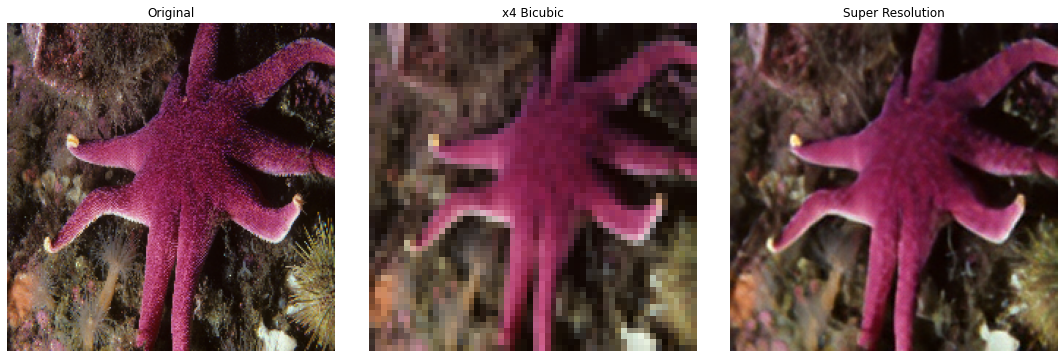

In [ ]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(1, 3)
fig.tight_layout()
plt.subplot(131)
plot_image(tf.squeeze(hr_image), title="Original")
plt.subplot(132)
fig.tight_layout()
plot_image(tf.squeeze(lr_image), "x4 Bicubic")
plt.subplot(133)
fig.tight_layout()
plot_image(tf.squeeze(fake_image), "Super Resolution")
plt.savefig("ESRGAN_DIV2K.jpg", bbox_inches="tight")
print("PSNR: %f" % psnr)

In [ ]:
train_path = '/content/DIV2K_train_HR'
val_path = '/content/DIV2K_valid_HR'